In [1]:
import batoid
import os
import yaml
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize
%matplotlib inline

In [2]:
# Step 1:  Dorsa's Function
def spread_analysis(z, dx, dy, theta_x, theta_y, wavelength, Filter, PRINT = False):
    
    #1)Bringing up the perfect (fiducial) telescope!
    LSST_fn = os.path.join(batoid.datadir, "LSST", "LSST_{}.yaml".format(Filter))
    config = yaml.load(open(LSST_fn))
    fiducial_telescope = batoid.parse.parse_optic(config['opticalSystem'])
    
    #2)Bringing up the perturbed telescope(result telescope as we apply changes to the focal plane)
    perturbed_telescope = fiducial_telescope.withGloballyShiftedOptic(
    "LSST.LSSTCamera.Detector",  # which optic to move
    [dx, dy, z] # how much to move it (in meters)
    )
    
    #3)Creating the circular grid of rays that I will be using 
    dirCos = batoid.utils.gnomicToDirCos(np.deg2rad(theta_x), np.deg2rad(theta_y))
    #rays = batoid.circularGrid(
        #perturbed_telescope.dist, perturbed_telescope.pupilSize/2,
        #perturbed_telescope.pupilSize/2*perturbed_telescope.pupilObscuration, 
        #dirCos[0], dirCos[1], -dirCos[2],
        #48, 192, wavelength*1e-9, perturbed_telescope.inMedium
    #)
    rays = batoid.rayGrid(
        10, # initial height of rays above primary mirror (in meters)
        10.0, # length of one side of the grid (in meters)
        dirCos[0], dirCos[1], -dirCos[2],  # direction cosines from above
        100, # number of rays on a side
        wavelength*1e-9, # wavelength in meters
        perturbed_telescope.inMedium, # initial refractive index of rays    
        )
    
    #4)Tracing the rays through the telescope and trimming the vignetted
    tracedRays, junk = perturbed_telescope.trace(rays) 
    unvignettedRays = tracedRays.trimVignetted()
    #understanding the amount of vignetted rays:
    total_rays = len(tracedRays)#total number of rays
    total_vignetted_rays = np.sum(tracedRays.isVignetted)#number of vignetted rays  (True is 1, False is 0)
    vignetted_rays_fraction = round(total_vignetted_rays/total_rays, 4)#calculating the fraction while rounding it to 4 decimal places
    #printing the results:
    if PRINT:
        print("Array of vignetted rays =", tracedRays.isVignetted)#array indicating which rays are vignetted
        print("Total number of rays =", total_rays)
        print("Total number of vignetted rays =", total_vignetted_rays)
        print("Fraction of vignetted rays =", vignetted_rays_fraction)
        
    #5)Calculations using the unvignetted rays:
    mean_x=np.mean(unvignettedRays.x)
    mean_y=np.mean(unvignettedRays.y)
    #Covarience:
    cov_matrix = np.cov(unvignettedRays.x, unvignettedRays.y)                        
    #rest of the calculations using the covarience matrix:
    sigma_x = np.sqrt(cov_matrix[0,0]) 
    sigma_y = np.sqrt(cov_matrix[1,1]) 
    sigma_cov = cov_matrix[0,1]# we do not take the square root because covarience sigma can be negative and we do not want cancellations 
    sigma_minus = (np.linalg.det(cov_matrix))**0.25 # compute determinant of the covarience matrix 
    sigma = np.hypot(sigma_x, sigma_y)
    sigma_plus= np.divide(sigma, np.sqrt(2))
    
    #Return
    return mean_x, mean_y, sigma_x, sigma_y, sigma, sigma_cov, sigma_plus, sigma_minus


In [3]:
raft_coord = np.array([[0, 0],
                       [0.682, 0.0],
                       [1.365, 0.0],
                       [-0.682, 0.0],
                       [-1.365, 0.0],
                       [0, 0.682],
                       [0.682, 0.682],
                       [1.365, 0.682],
                       [-0.682, 0.682],
                       [-1.365, 0.682],
                       [0, -0.682],
                       [0.682, -0.682],
                       [1.365, -0.682],
                       [-0.682, -0.682],
                       [-1.365, -0.682],
                       [0, -1.365],
                       [0.682, -1.365],
                       [-0.682, -1.365],
                       [0, 1.365],
                       [0.682, 1.365],
                       [-0.682, 1.365]])

#resolution = 10
#theta_X = np.linspace(-1.365, 1.365, resolution)
#theX, theY = np.meshgrid(theta_X,theta_X)
#thex = theX.reshape(resolution**2)
#they = theY.reshape(resolution**2)
#raft_coord = np.array([thex, they]).T


class FoV_variation(object):
    """
    Compute and plot all you need on 
    LSST FoV (Field of View) and do the
    useful plot.
    
    :coord: numpy array with theta_x and theta_y 
            coordinate on FoV
    """
    #the initialization step is important and have to make sure that it is spelled __init__.
    #and that there is "self" defined in it.
    # this is default value but you can change the values.
    def __init__(self, coord, wavelength = 625, Filter = "r", dx=0, 
                 dy=0, zs=np.linspace(-20e-6, 20e-6, 25), p0 = [15e-7, .24, 1e-6]):
        
        self.coord = coord #the self. makes it so that throughout the whole class it is defined
        self.wavelength = wavelength
        self.Filter = Filter
        self.dx = dx
        self.dy = dy
        self.zs = zs
        self.p0 = p0
        self.results = {}
        self.results_fit = {}
        self.in_list_for_plot = False
        
    def comp_single_coordinate(self, theta_x, theta_y, print_mode=True):
        """
        Compute variation in terms of focal plane position along the z axis
        for a given coordinate on the focal plane. 
        
        :theta_x: float. theta_x coordinate
        :theta_y: float. theta_y coordinate
        """
        results = [] #since self is not mentioned, this results is only defined in this function
        show = 0
        for z in self.zs:
            #append the results and apply the function but do not print the values while show=0
            if show == 0:
                results.append(spread_analysis(z, self.dx, self.dy, theta_x, theta_y, 
                                               self.wavelength, self.Filter, PRINT=print_mode))
            else:#I made if False to save time!However the option is there encase we wanted to take a look at the numbers.
                results.append(spread_analysis(z, self.dx, self.dy, theta_x, theta_y,
                                               self.wavelength, self.Filter, PRINT=False))  
            show += 1 #add 1 to the value of show so then it prints but only once which is what we want.
    
        results = np.array(results)  # turn the list-of-lists into a 2d array
        return results
    
    def comp_ellipticity_mag(self, results):
        
        ixx = results[:, 2]**2
        iyy = results[:, 3]**2
        ixy = results[:, 5]**2
        denom = ixx + iyy +2*(ixx*iyy - ixy**2)**(0.5)
        num = ixx - iyy + 2*ixy*1j
        e = num / denom
        mag_e = np.absolute(e)
        return mag_e
    
    def comp_ellipticity_real(self, results):
        
        ixx = results[:, 2]**2
        iyy = results[:, 3]**2
        ixy = results[:, 5]**2
        denom = ixx + iyy +2*(ixx*iyy - ixy**2)**(0.5)
        num = ixx - iyy 
        mag_e = num / denom
       
        return mag_e
    
    def comp_full_fov(self):
        
        i = 0
        for tx, ty in zip(self.coord[:,0], self.coord[:,1]):
            #print(tx, ty)
            results = self.comp_single_coordinate(tx, ty, print_mode=False)
            ellip_mag = self.comp_ellipticity_mag(results)
            ellip_real = self.comp_ellipticity_real(results)
            # I am putting the results for each given coodinate in self.coord,
            # and I am putting them in the empty dictionnary self.result that 
            # I defined in the __init__.
            self.results.update({'result_%i'%i:{'results':results,
                                                'ellip_mag':ellip_mag,
                                                'ellip_real':ellip_real,
                                                'theta_x':tx,
                                                'theta_y':ty}})
            def chi2(param):
                Y = self.results['result_%i'%i]['results'][:, 6]
                self.residuals = Y - self.data_fit_func(self.zs, param[0], param[1], param[2])
                return np.sum(self.residuals**2)#This is squared to take away the signs
            results_fit = optimize.fmin(chi2, self.p0, disp=False)
            self.results_fit.update({'result_%i'%i:{'sigma0':results_fit[0],
                                                     'dz0':results_fit[2],
                                                     'slope':results_fit[1]}}) 
            #we do self above to access throughout the class
            i += 1

    
    def data_fit_func(self, zs, sigma0, slope, dz0):# the fit function
        return np.sqrt(sigma0**2 + (slope * (zs - dz0))**2)

    def data_fit_plot(self, i, a, ax, color='b'): #plot of the fit function
        #ax.plot(self.zs*1e6, self.results['result_%i'%i]['results'][:, a]*1e6, 'o', c=color,
        #         label='Data:, $\\theta_X$=%.3f, $\\theta_Y$=%.3f, wavelength=%.3f, Filter=%s'
        #         %((self.results['result_%i'%i]['theta_x']
        #            ,self.results['result_%i'%i]['theta_y'], self.wavelength, self.Filter)))
      
        ax.plot(self.zs*1e6, self.data_fit_func(self.zs, self.results_fit['result_%i'%i]['sigma0'], 
                                                 self.results_fit['result_%i'%i]['slope'],
                                                 self.results_fit['result_%i'%i]['dz0'])*1e6,
                                                 color, label='fit result', alpha=0.5, lw=4)

    def plot_results_single(self, ind_list, AX=None, color='b', color_list=None):#plots specific results vs delta z
        #ind_list: a list of indexes or an index. 
        if type(ind_list) is list:#if you give the function a list(case2), 
                                  #meaning two different incoming angle on the same plot: creates a figure.
            self.in_list_for_plot = True# differentiates between the two cases of ind_list being a list or an index.
            plt.figure(figsize=(20,5))
            plt.subplots_adjust(wspace=0.4, hspace=0.3)#, right=0.8)
            #all the axi represent an individual subplot.
            ax1 = plt.subplot(1,4,1)
            ax2 = plt.subplot(1,4,2)
            ax3 = plt.subplot(1,4,3)
            ax4 = plt.subplot(1,4,4)
            AX = [ax1, ax2, ax3, ax4]#to call it in the function.
            string_save = ""# to save the figure at the end.
            ind_color = 0 # to assign numbers to colors, ex: blue=0.
            for n_plot in ind_list:#n_plot represent the specific plot index that we would like to have plotted together.
                #we did this step because if plots are together(on top of each other), we need to differentiate them.
                if color_list is not None:
                    ccc = color_list[ind_color]# there is a list of colors and then.
                                               #you pick the color by calling the assigned index to it.
                    ind_color += 1# looping over the colors 
                                  
                else:#if you dont provide color_list, it will use "color"
                    ccc = color
                self.plot_results_single(n_plot, AX=AX, color = ccc)
                #*we are calling the function within the function and taking a different path*
                #this is where the function gives out an index(case3).
                #we call the function again but now n_plot is an integer 
                #and not a list so it will go to the next step(below in the 'else:').
                string_save += '%i_'%(n_plot)#add the number of times you went through the function.
            #ax4.legend(bbox_to_anchor=(1.01, 0.7), loc=2, borderaxespad=0.,fontsize=14)
            plt.savefig('results_%s.pdf'%string_save)#now saving them.
        else:
            #when you give the function an index (case1) but, we could also get to this step with (case3).
            #this is essentially for when we do not want plots on top of each other.
            if not self.in_list_for_plot:#if you already went through case of the ind_list being a list, 
                                         #it will not go through this step because we do not want to have two plots.
                plt.figure(figsize=(20,5))
                plt.subplots_adjust(wspace=0.3, hspace=0.3)

            i = ind_list#case2: calls n_plot which is an index-->case3:we define i. case 1 also goes through this!
            #since we called the function again so it did not go through the steps for case2 so need to define AX.
            if AX is None:
                ax1 = plt.subplot(1,4,1)
                ax2 = plt.subplot(1,4,2)
                ax3 = plt.subplot(1,4,3)
                ax4 = plt.subplot(1,4,4)
            else:#this is for when we are coming from case3 to case1 where Ax is already defined.
                ax1 = AX[0]
                ax2 = AX[1]
                ax3 = AX[2]
                ax4 = AX[3]
            #below are the calculations and does not matter what case you are in between case 1 and 3.
            #just the plotting stuff but instead of plot, we use axi.
            ax1.plot(self.zs*1e6, (self.results['result_%i'%i]['results'][:, 0] - 
                                   np.mean(self.results['result_%i'%i]['results'][:, 0]))*1e6, 'o', c=color)
            ax1.set_ylim(-4, 6)
            ax1.axhline(y=0, xmin=0, alpha=0.3)
            ax1.axvline(x=0, ymin=0, alpha=0.3)
            ax1.set_xlabel('$\Delta$z (microns)', fontsize=16)
            ax1.set_ylabel(r'$\langle x \rangle$ (microns)', fontsize=16)
            ax1.tick_params(axis='both', which='major', labelsize=18)
            ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        
    
            ax2.scatter(self.zs*1e6, self.results['result_%i'%i]['results'][:, 6]*1e6, s=30, c=color)
            ax2.axhline(y=3.6, c="orange", alpha= 0.5)
            ax2.axhline(y=0, xmin=0, alpha=0.3)
            ax2.axvline(x=0, ymin=0, alpha=0.3)
            ax2.set_ylim(-1, 6)
            ax2.set_xlabel('$\Delta$z (microns)', fontsize=16)
            ax2.set_ylabel('$\sigma$ (microns)', fontsize=16)
            ax2.tick_params(axis='both', which='major', labelsize=18)
            self.data_fit_plot(i, a=6, ax = ax2, color=color)
        
    
            ax3.plot(self.zs*1e6, self.results['result_%i'%i]['ellip_mag'], 'o', c=color)
            ax3.axhline(y=0, xmin=0, alpha=0.3)
            ax3.axvline(x=0, ymin=0, alpha=0.3)
            ax3.set_ylim(0, 0.6)
            ax3.set_xlabel('$\Delta$z (microns)', fontsize=16)
            ax3.set_ylabel(r'|$\epsilon$|', fontsize=16)
            ax3.tick_params(axis='both', which='major', labelsize=18)
            
            
            #plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        
            ax4.plot(self.zs*1e6, self.results['result_%i'%i]['ellip_real'], 'o', c=color,
                    label = 'Data:, $\\theta_X$ = %.3f, $\\theta_Y$ = %.3f'%((self.results['result_%i'%i]['theta_x']
                    ,self.results['result_%i'%i]['theta_y'])))
            ax4.axhline(y=0, xmin=0, alpha=0.3)
            ax4.axvline(x=0, ymin=0, alpha=0.3)
            ax4.set_ylim(-0.5, 0.5)
            ax4.set_xlabel('$\Delta$z (microns)', fontsize=16)
            ax4.set_ylabel(r'Re($\epsilon$)', fontsize=16)
            ax4.tick_params(axis='both', which='major', labelsize=18)
            #plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        
        
                
    def plot_raft_single(self, i):#plots the sigma vs delta z for each specific raft coordinate
        #the i here represents one of the 21 coordinates
        plt.plot(self.zs*1e6, self.results['result_%i'%i]['results'][:, 4]*1e6, 'o', 
                 label='$\\theta_X$=%.3f, $\\theta_Y$=%.3f, wavelength=%.3f, Filter=%s'
                 %((self.results['result_%i'%i]['theta_x']
                    ,self.results['result_%i'%i]['theta_y'], self.wavelength, self.Filter)))
        plt.legend(fontsize=12)
        plt.xlim(-20,20)
        plt.ylim(0,10)
        #plt.xlabel('dz (microns)', fontsize=12)
        #plt.ylabel('sigma (microns)', fontsize=12)
    
    def plot_all(self): #plots the sigma vs delta z for all the raft coordinates
        plt.figure(figsize=(25,25))
        plt.subplots_adjust(top=0.96,hspace=0, wspace=0)
        for i in range(len(self.coord)):
            plt.subplot(7,3,i+1)
            # remove the xticks in all the subplot except the 
            # 3 at the bottom
            if i+1 not in [19, 20, 21]:
                plt.xticks([],[])
            if i+1 not in [1,4,7,10,13,16,19]:
                plt.yticks([],[])
            if i+1 == 20:
                plt.xlabel('$\Delta$z (microns)', fontsize=18)
            if i+1 == 10:
                plt.ylabel('$\sigma$ (microns)', fontsize=18)
            self.plot_raft_single(i)
            #self.data_fit_plot(i, a=4)
        plt.suptitle('$\sigma$ vs $\Delta$z',fontsize=25)
    
    def plot_param(self, ind_list, AX=None, color='b', color_list=None):#plot of angle variation vs fit function param 
        if type(ind_list) is list:
            self.in_list_for_plot = True
            plt.subplots_adjust(wspace=0.4, hspace=0.3)
            ax1 = plt.subplot(1,3,1)
            ax2 = plt.subplot(1,3,2)
            ax3 = plt.subplot(1,3,3)
            AX = [ax1, ax2, ax3]
            string_save = ""
            ind_color = 0
            for n_plot in ind_list:
                if color_list is not None:
                    ccc = color_list[ind_color]
                    ind_color += 1
                else:
                    ccc = color
                self.plot_results_single(n_plot, AX=AX, color = ccc)
                string_save += '%i_'%(n_plot)
            plt.savefig('results_%s.pdf'%string_save)
        else:
            if not self.in_list_for_plot:
                plt.figure(figsize=(20,5))
                plt.subplots_adjust(wspace=0.3, hspace=0.3)
            i = ind_list
            if AX is None:
                ax1 = plt.subplot(1,3,1)
                ax2 = plt.subplot(1,3,2)
                ax3 = plt.subplot(1,3,3)
            else:
                ax1 = AX[0]
                ax2 = AX[1]
                ax3 = AX[2]
            X = self.coord[:,0] 
            #the initial array of zeros:
            Y = np.zeros((3,len(self.coord)))
            for i in range(len(self.coord)):
                Y[0, i] = self.results_fit['result_%i'%i]['sigma0']*1e06
                Y[1, i] = self.results_fit['result_%i'%i]['slope']
                Y[2, i] = self.results_fit['result_%i'%i]['dz0']*1e06

            plt.figure(figsize=(20,5))
            plt.subplots_adjust(wspace=0.4, hspace=0.3)
            titles = ['$\sigma_0 (microns)$','slope ($s$)','$\Delta$z (microns)']

            for i in range(3):
                axi.xlabel('$\\theta_X$', fontsize=18)
                axi.ylabel(titles[i], fontsize=18)
                axi.scatter(X, Y[i], c='b')
                axi.axhline(y=0, xmin=0, alpha=0.3)
                axi.axvline(x=0, ymin=0, alpha=0.3)
                axi.tick_params(axis='both', which='major', labelsize=18)
                if i==0:
                    plt.ylim(0.5,5)
                if i==1:
                    plt.ylim(.253, .258)
                    #plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
            plt.savefig("grid.pdf")#save the grid in downloads 
    

fov = FoV_variation(raft_coord)
fov.comp_full_fov() #this has to be here!
#fov.plot_all()
#fov.plot_param()

IndexError: list index out of range

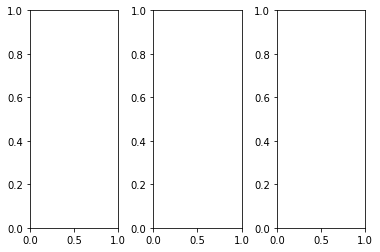

In [5]:
num = 69
theta_x = np.linspace(0, 1.7, num)
raft_coord = np.zeros((num,2))
raft_coord[:, 0] = theta_x

filter_wave = {'u':np.array([315, 350, 410]),
               'g':np.array([385, 475, 575]),
               'r':np.array([525, 625, 710]), 
               'i':np.array([660, 750, 850]), 
               'z':np.array([790, 875, 965]),
               'y':np.array([875, 975, 1095])}

for Filter in filter_wave:
    for i in range(3):
        fov = FoV_variation(raft_coord, Filter=Filter, wavelength= filter_wave[Filter][i])
        fov.comp_full_fov()
        fov.plot_param([0,1,2], color_list=['b','g','r'])

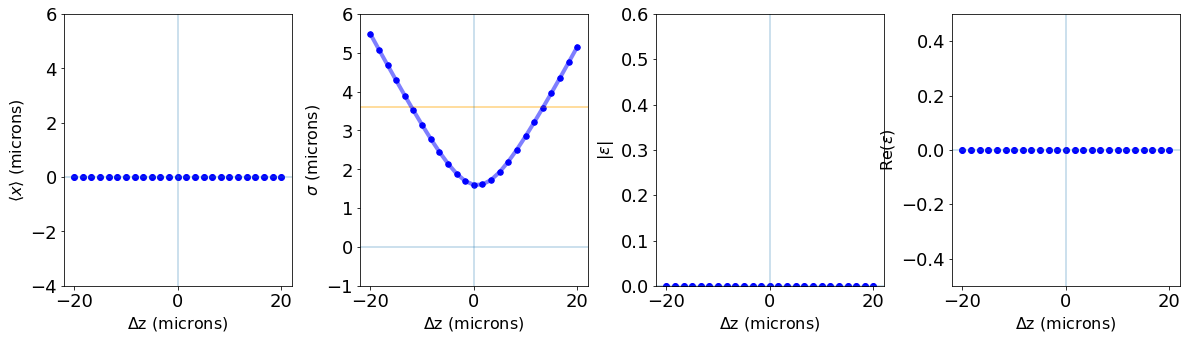

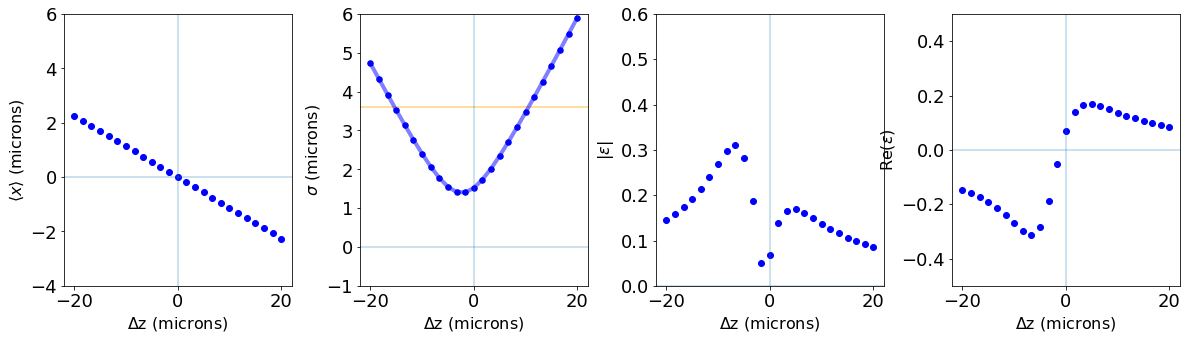

In [6]:
raft_coord = np.array([[0, 0],
                       [1.5, 0]])

fov = FoV_variation(raft_coord, wavelength=625)
fov.comp_full_fov() #this has to be here!
fov.plot_results_single(0)
fov.plot_results_single(1)

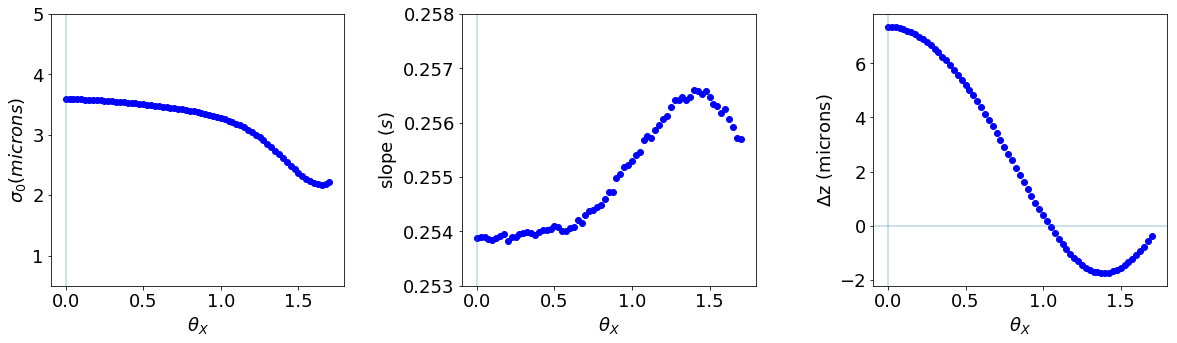

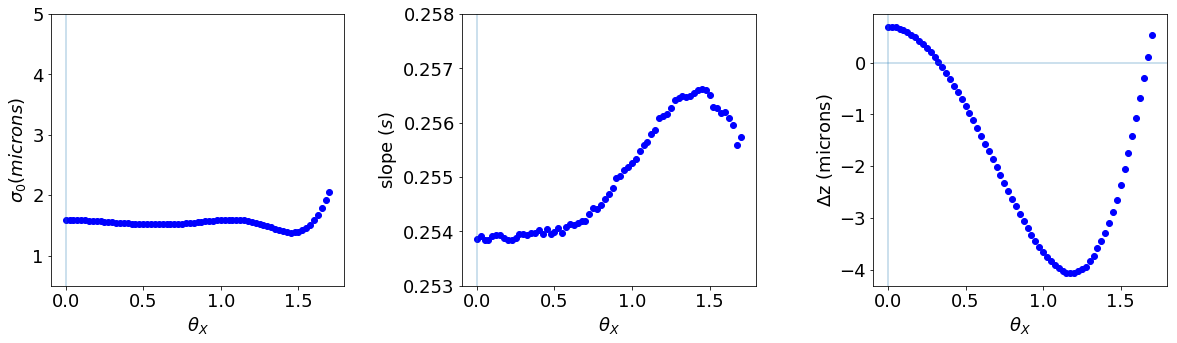

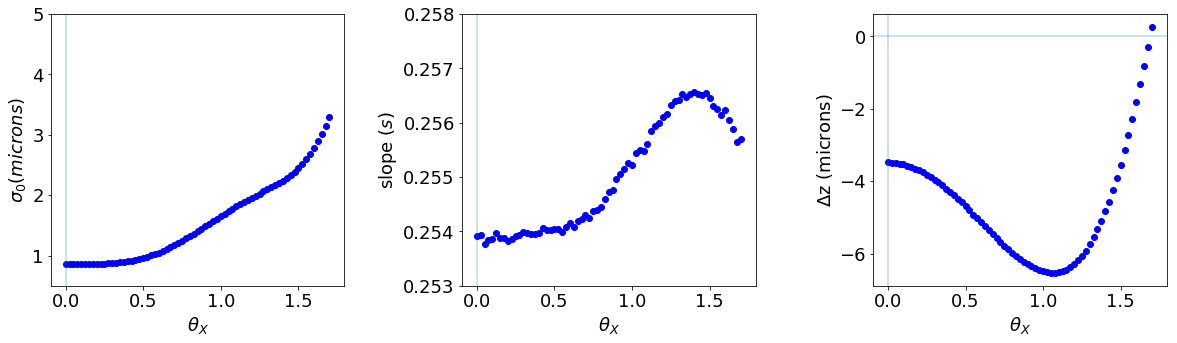

In [10]:
num = 69
theta_x = np.linspace(0, 1.7, num)
raft_coord = np.zeros((num,2))
raft_coord[:, 0] = theta_x
wavelengths = [525, 625, 700]
for wavelength in wavelengths:
    fov = FoV_variation(raft_coord, wavelength=wavelength)
    fov.comp_full_fov()
    fov.plot_param()

In [75]:
filter_wave = {'u':np.array([315, 350, 410]),
               'g':np.array([385, 475, 575]),
               'r':np.array([525, 625, 710]), 
               'i':np.array([660, 750, 850]), 
               'z':np.array([790, 875, 965]),
               'y':np.array([875, 975, 1095])}

#Filters = filter_wave.keys() Do not do this because it creates a list and it takes longer to go through a list rather than a dictionary
#I = [0,1,2]


#filter_wave.keys()
#filter_wave.values()
#for wavelength in wavelengths:
    #print(wavelength)

#filter_wave['u'][0]


KeyboardInterrupt: 

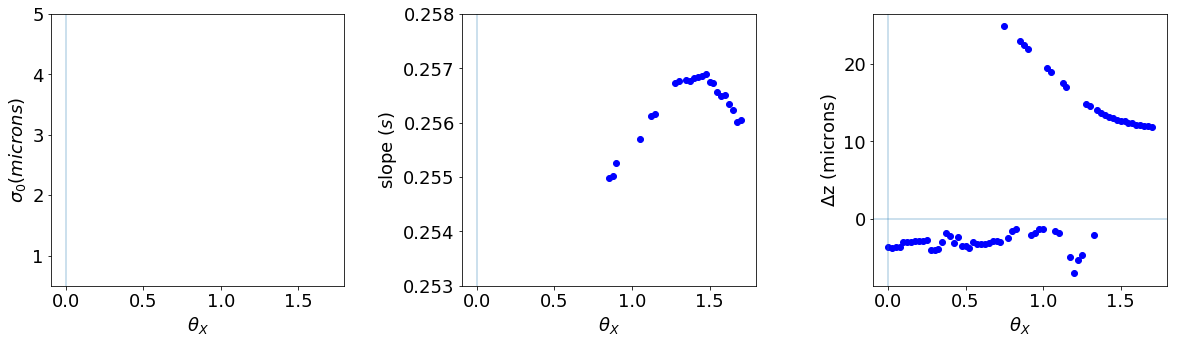

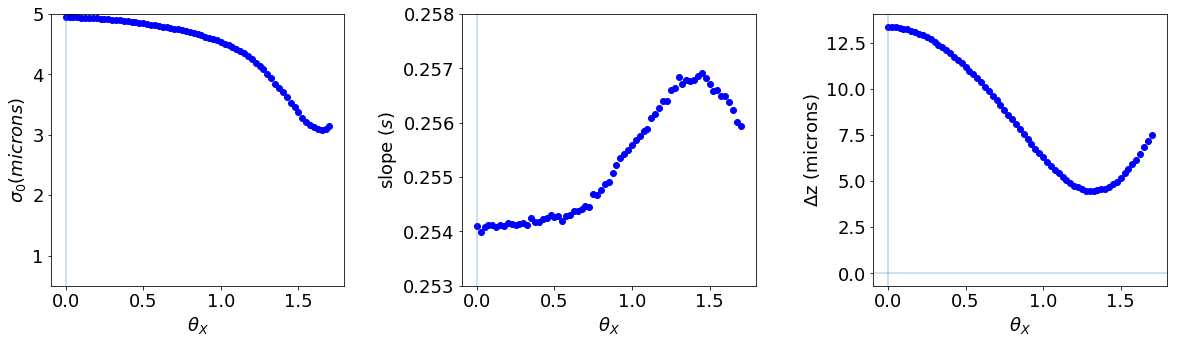

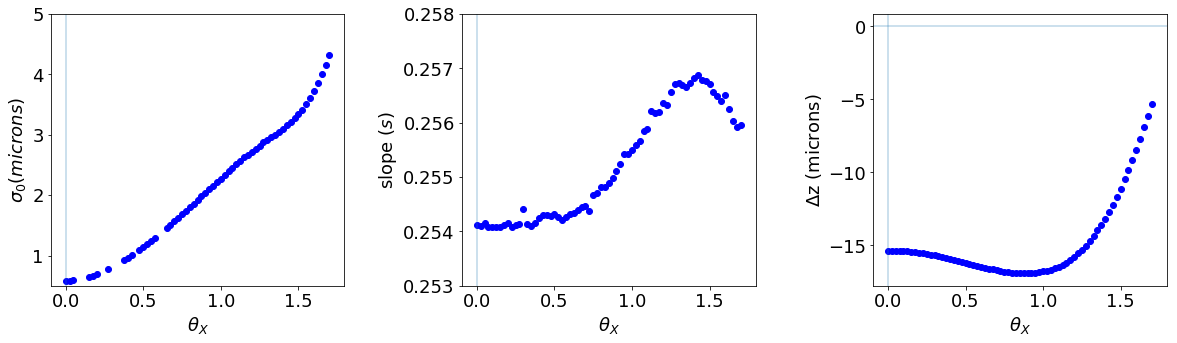

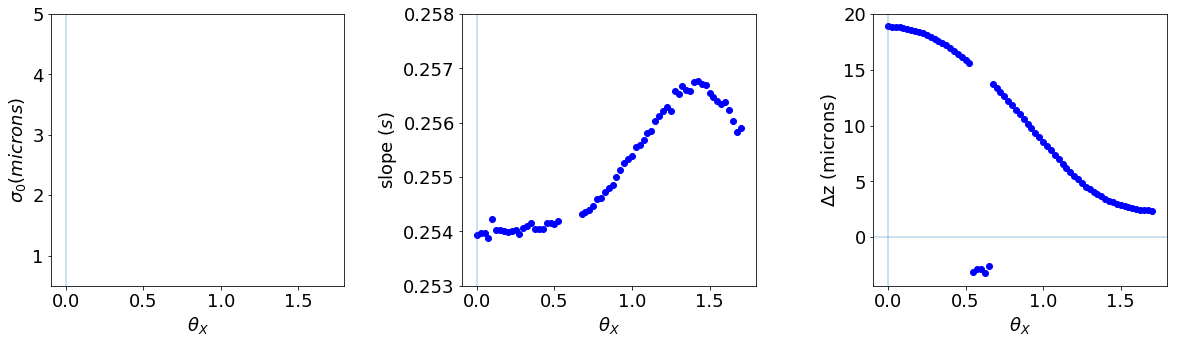

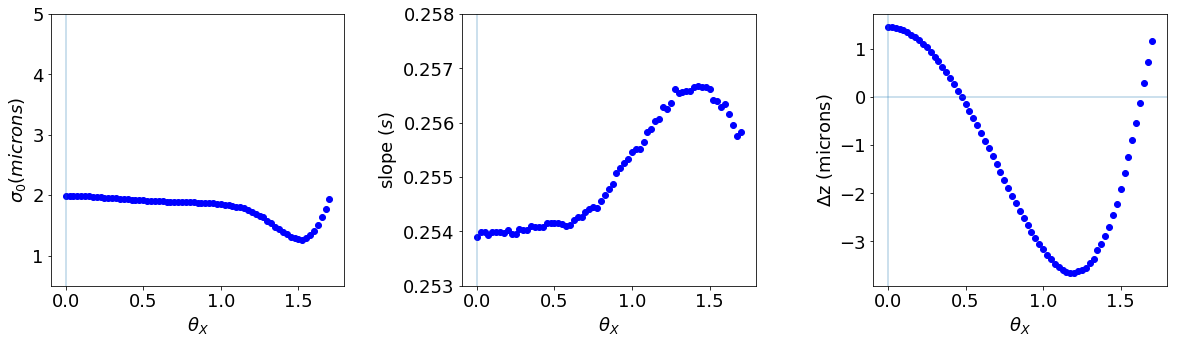

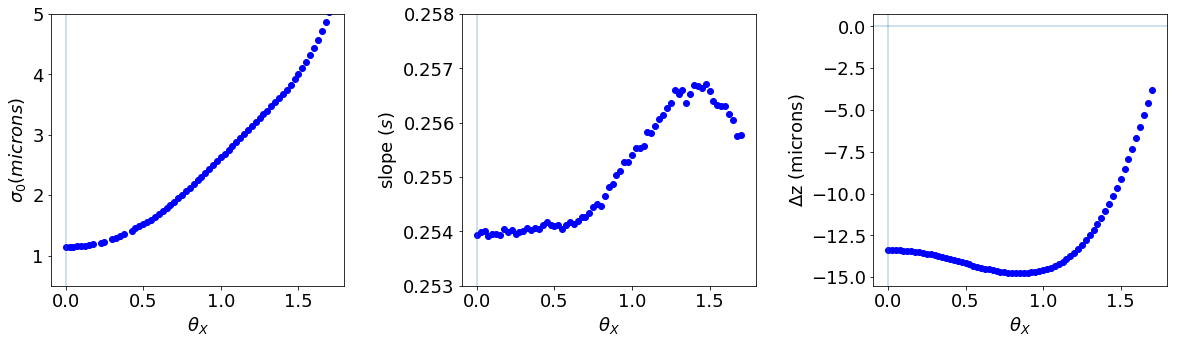

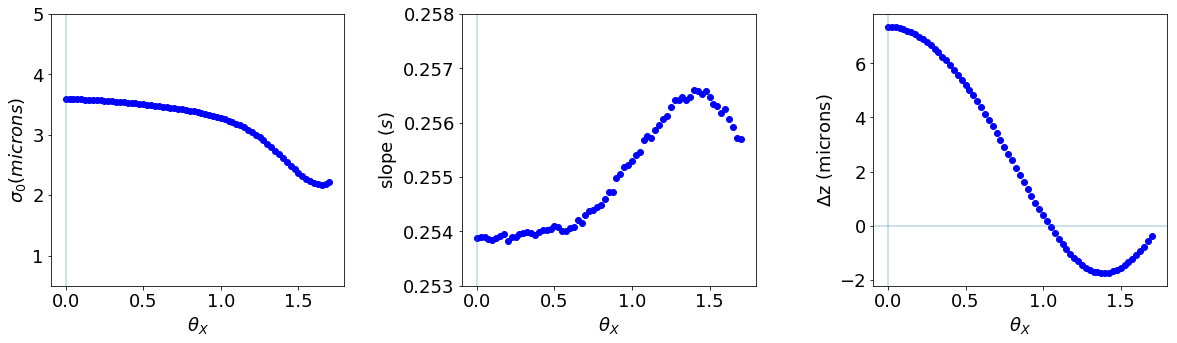

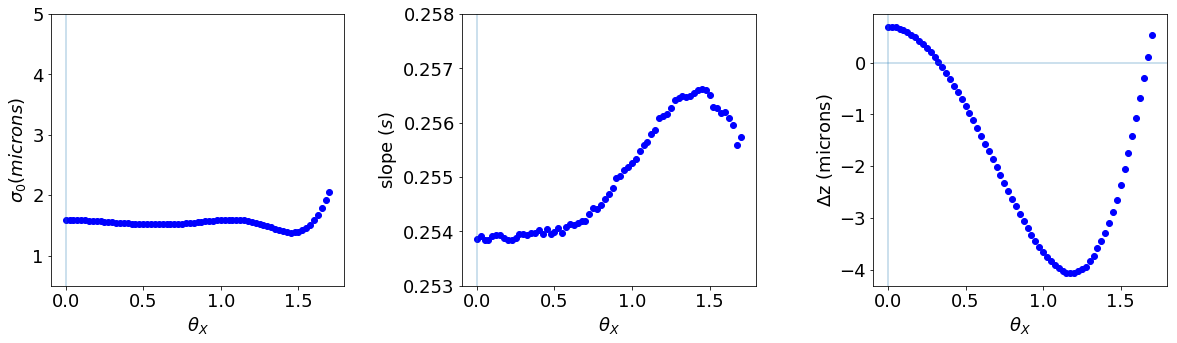

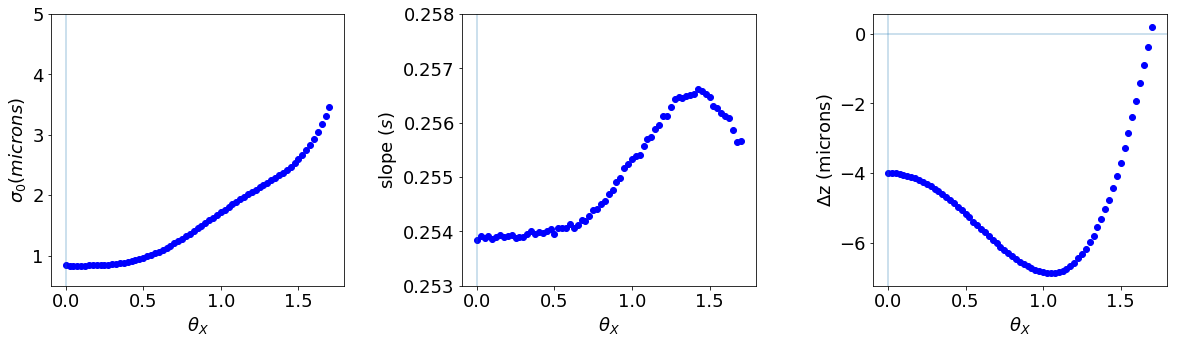

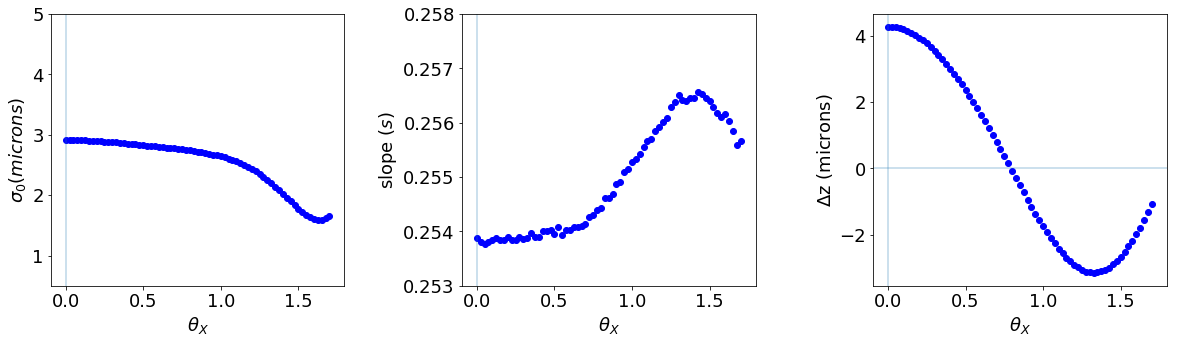

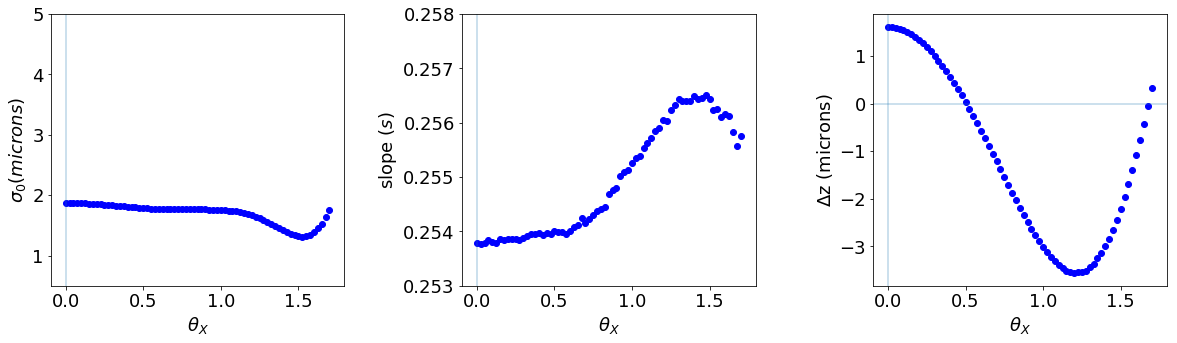

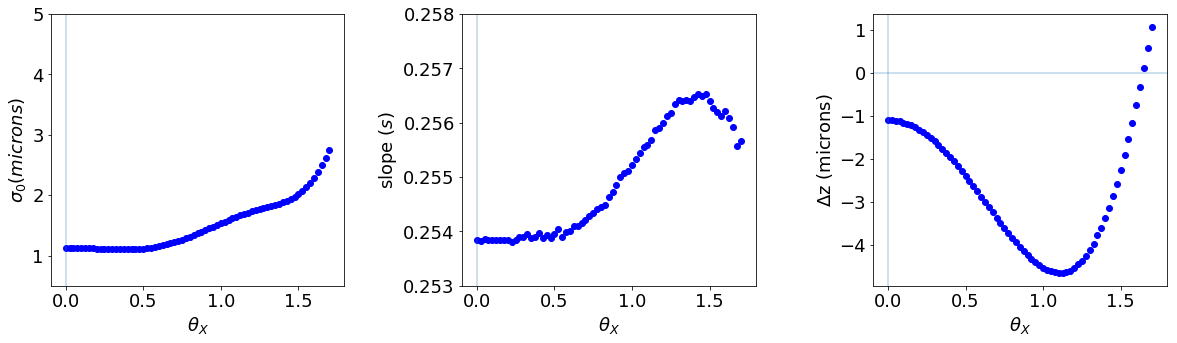

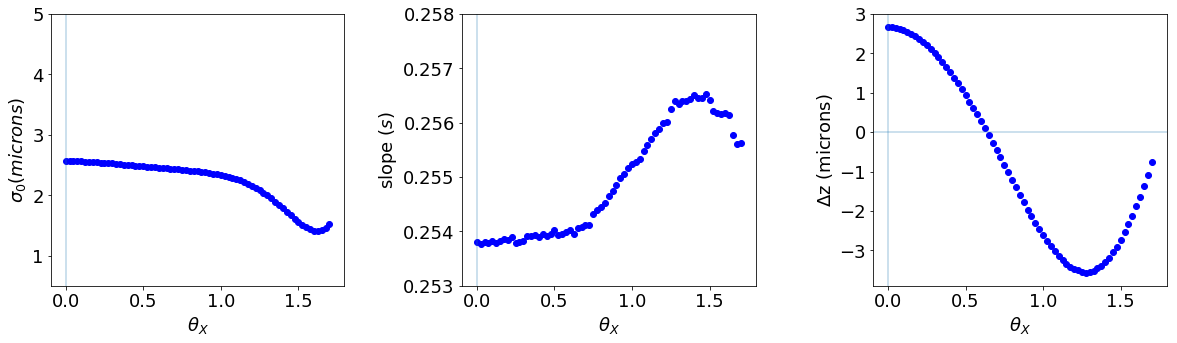

In [91]:
num = 69
theta_x = np.linspace(0, 1.7, num)
raft_coord = np.zeros((num,2))
raft_coord[:, 0] = theta_x

for Filter in filter_wave:
    for i in range(3):
        fov = FoV_variation(raft_coord, Filter=Filter, wavelength= filter_wave[Filter][i])
        fov.comp_full_fov()
        fov.plot_param()

Text(0.5,1,'b')

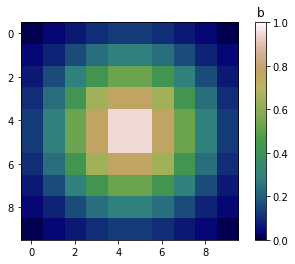

In [8]:
np.random.seed(42)

#X = np.random.uniform(-10,10,size=10000)
#Y = np.random.uniform(-10,10,size=10000)
#Z = np.exp(-0.5*(X**2+Y**2)/(5.)**2)

#plt.scatter(X, Y, c=Z, vmin=0, vmax=1, cmap=plt.get_cmap('gist_earth'),  s=60, marker='o',edgecolors='k', lw=0)

X = np.linspace(-10,10, 10)
X, Y = np.meshgrid(X,X)
Z = np.exp(-0.5*(X**2+Y**2)/(5.)**2)
plt.imshow(Z, vmin=0, vmax=1, cmap=plt.get_cmap('gist_earth'))#, interpolation='bicubic')

cbar = plt.colorbar()
#cbar.ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
cbar.ax.set_title('b')
#cbar.ax.xaxis.set_label_position('top')

In [9]:
#plt.imshow?

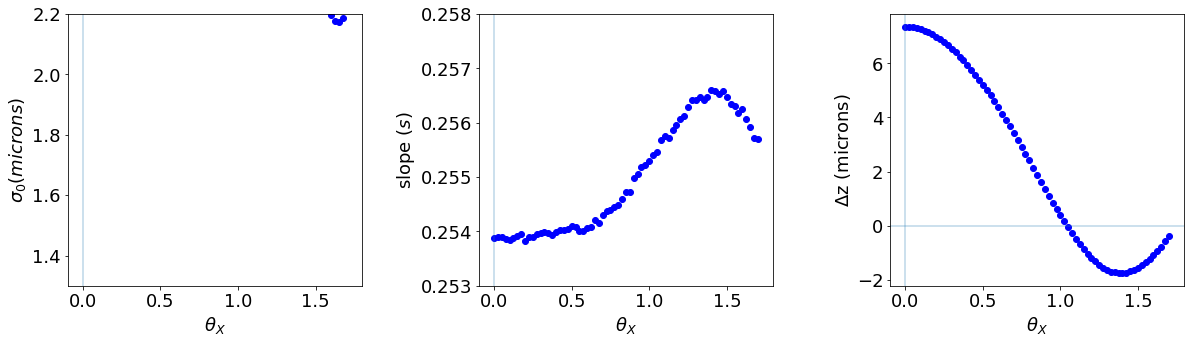

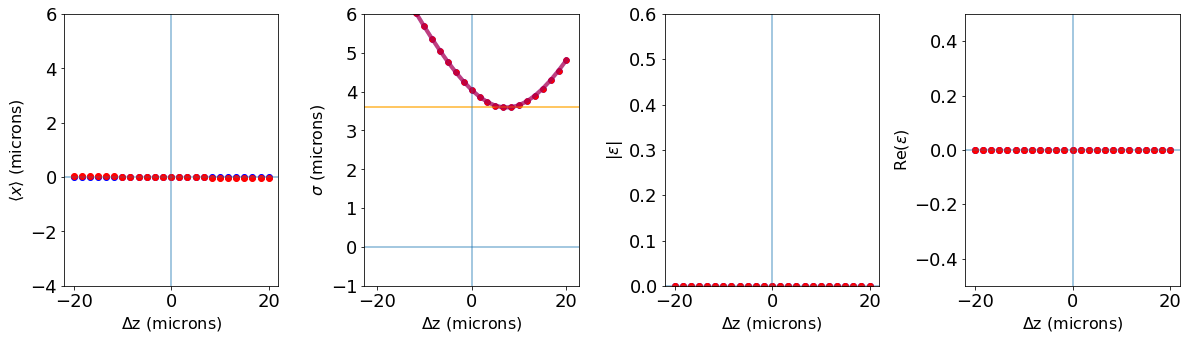

In [10]:
num = 69
theta_x = np.linspace(0, 1.7, num)
raft_coord = np.zeros((num,2))
raft_coord[:, 0] = theta_x
fov = FoV_variation(raft_coord, wavelength=525)
fov.comp_full_fov()
fov.plot_grid()
fov.plot_results_single([0,1], color_list=['b', 'r'])

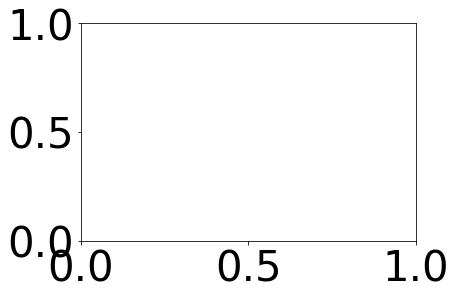

In [11]:
plt.figure()
plt.tick_params(axis='both', labelsize=42)

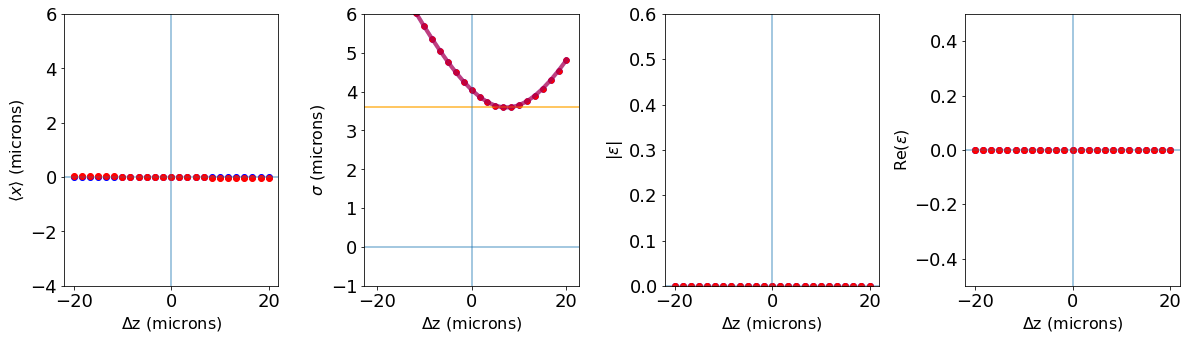

In [12]:

fov.plot_results_single([0,1], color_list=['b', 'r'])

In [85]:
A = []
B = {}

for i in range(10000000):
    A.append('%i'%i)
    B.update({'%i'%i:{}})

In [90]:
import time

start = time.time()
'800000' in B
end = time.time()
print(end-start)

3.6716461181640625e-05
